# IS5126 Individual Assignment 1 - HW1

In [ ]:
%pip install crawl4ai
%pip install beautifulsoup4 lxml requests
!playwright install
print("✅ All libraries installed successfully!")

In [ ]:
# Import required libraries
import json
import os
from typing import List, Dict, Any, Optional
from openai import OpenAI
from getpass import getpass
import traceback
import asyncio
import nest_asyncio
import time
import re
import csv
import json
from typing import Dict, List, Any
from crawl4ai import AsyncWebCrawler
from bs4 import BeautifulSoup
from pydantic import BaseModel, Field
from typing import List, Optional, Dict, Any
import openai
from openai import OpenAI
import time
import logging
from datetime import datetime
import os
import json
import openai
import os
from typing import List, Dict, Any, Optional
from datetime import datetime
import nest_asyncio, asyncio

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set font for visualization
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Enable nest_asyncio to support async operations in Jupyter
nest_asyncio.apply()

print("✅ All libraries imported successfully!")


## Part 1: Wikipedia Scraper Implementation:
– WikipediaScraper class with all required methods
– Demonstration of scraping your chosen 5+ Wikipedia articles
– Explanation of how your articles relate to your research domain
– Error handling examples with sample outputs

In [ ]:
class WikipediaScraper:
    def __init__(self, base_urls: List[str]):
        """
        Initialize Wikipedia scraper

        Args:
            base_urls: List of Wikipedia article URLs to scrape
        """
        self.base_urls = base_urls
        self.scraped_data = []
        self.rate_limit_delay = 2  # Request interval (seconds) to avoid overloading Wikipedia servers

        # Validate URL format
        self._validate_urls()

    def _validate_urls(self):
        """Validate if URLs are valid Wikipedia links"""
        valid_urls = []
        for url in self.base_urls:
            if self._is_valid_wikipedia_url(url):
                valid_urls.append(url)
            else:
                print(f"Warning: Skipping invalid Wikipedia URL: {url}")

        if not valid_urls:
            raise ValueError("No valid Wikipedia URLs provided")

        self.base_urls = valid_urls
        print(f"Validation passed, {len(valid_urls)} valid URLs found")

    def _is_valid_wikipedia_url(self, url: str) -> bool:
        """Check if URL is a valid Wikipedia URL"""
        try:
            return (
                'wikipedia.org' in url and
                '/wiki/' in url
            )
        except:
            return False

    def _looks_like_html(self, content: str) -> bool:
        """Determine whether a string looks like HTML"""
        try:
            return bool(content and content.lstrip().startswith("<"))
        except Exception:
            return False

    def _html_to_text(self, html: str) -> str:
        """Convert Wikipedia HTML to cleaner plain text (keep title and paragraphs)"""
        try:
            soup = BeautifulSoup(html, "lxml")

            # Title
            title_node = soup.select_one("#firstHeading")
            title_text = title_node.get_text(" ", strip=True) if title_node else ""

            # Main content container
            content = soup.select_one("#mw-content-text") or soup

            # Noise selectors to remove
            noise_selectors = [
                "#toc", ".mw-references-wrap", "table.infobox",
                "div.navbox", "table.metadata", "div.hatnote",
                "script", "style", "noscript",
            ]
            for sel in noise_selectors:
                for node in content.select(sel):
                    node.decompose()

            # Paragraph text
            paragraphs = []
            for p in content.select("p"):
                text = p.get_text(" ", strip=True)
                text = re.sub(r"\s*\[\d+\]", "", text)  # remove footnote like [1]
                if text:
                    paragraphs.append(text)

            combined = ((title_text + "\n\n") if title_text else "") + "\n\n".join(paragraphs)
            combined = re.sub(r"\n{3,}", "\n\n", combined).strip()
            return combined
        except Exception:
            return html

    async def scrape_article(self, url: str) -> Dict[str, Any]:
        """
        Scrape a single Wikipedia article

        Args:
            url: Article URL

        Returns:
            Dictionary containing article information
        """
        try:
            print(f"Starting to scrape article: {url}")

            async with AsyncWebCrawler(verbose=False) as crawler:
                # Scrape article content
                result = await crawler.arun(url)

                if result.success:
                    # Extract article information
                    article_data = self._extract_article_info(result, url)
                    print(f"Successfully scraped article: {article_data.get('title', 'Unknown')}")
                    return article_data
                else:
                    error_msg = result.error_message if hasattr(result, 'error_message') else 'Unknown error'
                    print(f"Scraping failed: {error_msg}")
                    return self._create_error_response(url, error_msg)

        except Exception as e:
            print(f"Error occurred while scraping article {url}: {str(e)}")
            return self._create_error_response(url, str(e))

    def _extract_article_info(self, result, url: str) -> Dict[str, Any]:
        """Extract article info from scraping result"""
        try:
            content = result.html

            # Extract title
            title = self._extract_title(content, url)

            # Extract main content
            main_content = self._extract_main_content(content)

            # Extract key sections
            sections = self._extract_sections(content)

            # Clean content
            cleaned_content = self.clean_content(main_content)

            return {
                'url': url,
                'title': title,
                'main_content': cleaned_content,
                'sections': sections,
                'raw_content_length': len(content),
                'cleaned_content_length': len(cleaned_content),
                'scraped_at': time.strftime('%Y-%m-%d %H:%M:%S'),
                'status': 'success'
            }

        except Exception as e:
            print(f"Error extracting article info: {str(e)}")
            return self._create_error_response(url, f"Extraction failed: {str(e)}")

    def _extract_title(self, content: str, url: str) -> str:
        """Extract article title from HTML content"""
        try:
            soup = BeautifulSoup(content, 'html.parser')

            # Prefer title from h1
            h1_title = soup.find('h1')
            if h1_title:
                title_text = h1_title.get_text(strip=True)
                if title_text and len(title_text) > 0:
                    return title_text

            # Fallback: page <title>
            title_tag = soup.find('title')
            if title_tag:
                title_text = title_tag.get_text(strip=True)
                # Remove suffix like " - Wikipedia"
                if ' - Wikipedia' in title_text:
                    title_text = title_text.split(' - Wikipedia')[0]
                if title_text and len(title_text) > 0:
                    return title_text

            return "Unknown Title"

        except Exception as e:
            print(f"Error extracting title: {str(e)}")
            return "Unknown Title"

    def _extract_main_content(self, content: str) -> str:
        """Extract main article content from HTML"""
        try:
            soup = BeautifulSoup(content, 'html.parser')

            # Locate main content area
            main_content = soup.select_one('#mw-content-text')
            if not main_content:
                main_content = soup

            # Remove noisy elements
            noise_selectors = [
                '#toc', '.mw-references-wrap', 'table.infobox',
                'div.navbox', 'table.metadata', 'div.hatnote',
                'script', 'style', 'noscript', 'table', 'nav',
                '.mw-editsection', '.mw-cite-backlink', '.thumb',
                '.image', 'sup.reference', 'span.mw-ref'
            ]

            for selector in noise_selectors:
                for element in main_content.select(selector):
                    element.decompose()

            # Collect all paragraph text
            paragraphs = main_content.find_all('p')
            content_list = []

            for p in paragraphs:
                text = p.get_text(strip=True)
                if text and len(text) > 10:  # filter out very short paragraphs
                    # remove footnote numbers and artifacts
                    text = re.sub(r'\s*\[\d+\]', '', text)
                    text = re.sub(r'\[\s*\]', '', text)
                    content_list.append(text)

            if content_list:
                return '\n\n'.join(content_list)
            else:
                return "Unable to extract valid content"

        except Exception as e:
            print(f"Failed to extract content from HTML: {str(e)}")
            return content[:1000]  # return first 1000 chars as fallback

    def _extract_sections(self, content: str) -> List[Dict[str, str]]:
        """Extract heading structure from HTML (without content)"""
        try:
            soup = BeautifulSoup(content, 'html.parser')

            # Locate main content area
            main_content = soup.select_one('#mw-content-text')
            if not main_content:
                main_content = soup

            sections = []

            # Find all heading tags
            headings = main_content.find_all(['h1', 'h2', 'h3'])

            for heading in headings:
                level = int(heading.name[1])  # h1->1, h2->2, h3->3
                heading_text = heading.get_text(strip=True)

                # Skip some headings
                if self._should_skip_heading(heading_text):
                    continue

                sections.append({
                    'level': level,
                    'heading': heading_text
                })

            return sections

        except Exception as e:
            print(f"Failed to extract sections from HTML: {str(e)}")
            return []

    def _should_skip_heading(self, heading_text: str) -> bool:
        """Decide whether a heading should be skipped"""
        skip_patterns = [
            'Contents', 'References', 'External links', 'Further reading',
            'See also', 'Notes', 'Bibliography', 'Sources', 'Citations', 'Footnotes'
        ]

        for pattern in skip_patterns:
            if pattern.lower() in heading_text.lower():
                return True
        return False

    def clean_content(self, raw_content: str) -> str:
        """Clean and pre-process scraped content"""
        if not raw_content:
            return ""

        try:
            # Remove excessive whitespace and newlines
            cleaned = re.sub(r'\n{3,}', '\n\n', raw_content)
            cleaned = re.sub(r'[ \t]+', ' ', cleaned)

            # Remove footnote references
            cleaned = re.sub(r'\s*\[\d+\]', '', cleaned)

            # Ensure proper blank lines between paragraphs
            cleaned = re.sub(r'\n{3,}', '\n\n', cleaned)

            return cleaned.strip()

        except Exception as e:
            print(f"Failed to clean content: {e}")
            return raw_content

    async def scrape_all_articles(self, urls: List[str]) -> List[Dict[str, Any]]:
        """Scrape all articles"""
        print(f"Starting batch scrape for {len(urls)} articles")

        all_results = []

        for i, url in enumerate(urls):
            try:
                print(f"Progress: {i+1}/{len(urls)}")

                # Scrape single article
                article_data = await self.scrape_article(url)
                all_results.append(article_data)

                # Rate limit: add delay between requests
                if i < len(urls) - 1:  # not the last one
                    print(f"Waiting {self.rate_limit_delay} seconds...")
                    await asyncio.sleep(self.rate_limit_delay)

            except Exception as e:
                print(f"Error while scraping article {url}: {str(e)}")
                all_results.append(self._create_error_response(url, str(e)))

        self.scraped_data = all_results
        print(f"Batch scrape completed, successfully scraped {len([r for r in all_results if r.get('status') == 'success'])} articles")

        return all_results

    def _create_error_response(self, url: str, error_message: str) -> Dict[str, Any]:
        """Create an error response"""
        return {
            'url': url,
            'title': 'Error',
            'main_content': '',
            'sections': [],
            'error': error_message,
            'status': 'error',
            'scraped_at': time.strftime('%Y-%m-%d %H:%M:%S')
        }

    def save_to_json(self, data: List[Dict[str, Any]], filename: str):
        """Save scraped data to a JSON file"""
        try:
            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=2)
            print(f"Full data saved to: {filename}")
        except Exception as e:
            print(f"Error saving JSON file: {str(e)}")

    def save_content_to_markdown(self, data: List[Dict[str, Any]], filename: str):
        """Save main contents of the results to a Markdown file"""
        try:
            lines = []
            for i, item in enumerate(data, start=1):
                title = item.get('title', f'Article {i}')
                url = item.get('url', '')
                main = item.get('main_content', '').strip()

                lines.append(f"# {title}")
                if url:
                    lines.append(f"Source: {url}")
                lines.append("")

                if main:
                    lines.append(main)
                    lines.append("")

                lines.append("---\n")

            output = "\n".join(lines).strip() + "\n"
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(output)
            print(f"Main content saved to: {filename}")
        except Exception as e:
            print(f"Error saving main content Markdown file: {str(e)}")

    def save_sections_to_markdown(self, data: List[Dict[str, Any]], filename: str):
        """Save section information of the results to a Markdown file"""
        try:
            lines = []
            for i, item in enumerate(data, start=1):
                title = item.get('title', f'Article {i}')
                url = item.get('url', '')
                sections = item.get('sections', [])

                lines.append(f"# {title}")
                if url:
                    lines.append(f"Source: {url}")
                lines.append("")

                if isinstance(sections, list) and sections:
                    for s in sections:
                        if isinstance(s, dict):
                            heading = s.get('heading') or s.get('title') or 'Section'
                            content = s.get('content') or s.get('text') or ''
                            lines.append(f"## {heading}")
                            if content:
                                lines.append(content)
                            lines.append("")
                        else:
                            lines.append(str(s))
                            lines.append("")
                else:
                    lines.append("No sections available")
                    lines.append("")

                lines.append("---\n")

            output = "\n".join(lines).strip() + "\n"
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(output)
            print(f"Section information saved to: {filename}")
        except Exception as e:
            print(f"Error saving section information Markdown file: {str(e)}")

    def get_summary(self) -> Dict[str, Any]:
        """Get scraping summary"""
        if not self.scraped_data:
            return {"message": "No scraped data"}

        successful = [r for r in self.scraped_data if r.get('status') == 'success']
        failed = [r for r in self.scraped_data if r.get('status') == 'error']

        total_content_length = sum(r.get('cleaned_content_length', 0) for r in successful)

        return {
            'total_articles': len(self.scraped_data),
            'successful_scrapes': len(successful),
            'failed_scrapes': len(failed),
            'total_content_length': total_content_length,
            'average_content_length': total_content_length // len(successful) if successful else 0,
            'success_rate': len(successful) / len(self.scraped_data) * 100
        }

print("✅ WikipediaScraper class definition completed")


In [ ]:
# Utility function to convert search keywords to Wikipedia URLs
def build_wikipedia_urls(terms):
    """Generate Wikipedia article URL list from keywords (English articles).
    - Rules: Replace spaces with underscores; trim whitespace; deduplicate.
    - Note: If keywords are not English or non-standard titles, additional processing/search may be needed.
    """
    if not terms:
        return []
    base = "https://en.wikipedia.org/wiki/"
    urls = []
    seen = set()
    for t in terms:
        if not isinstance(t, str):
            continue
        title = t.strip().replace(" ", "_")
        if not title:
            continue
        url = base + title
        if url not in seen:
            urls.append(url)
            seen.add(url)
    return urls


In [ ]:
async def scrape_scientific_discoveries(search_terms_list: Optional[List[str]] = None):
    """Scrape scientific discovery related Wikipedia articles"""
    print("🚀 Starting to scrape scientific discovery related Wikipedia articles...")
    print("=" * 60)
    if search_terms_list != None:
        scientific_urls = build_wikipedia_urls(search_terms_list)
        print(f"✅ Generated {len(scientific_urls)} Wikipedia URLs")
    else:
        search_terms = [
        "CRISPR",
        "RNA vaccine",
        "Gravitational wave",
        "Higgs boson",
        "Quantum computing",
        "Ancient DNA",
        "Water on Mars",
        "Penicillin"
        ]
        scientific_urls = build_wikipedia_urls(search_terms)

    print(scientific_urls)
    scraper = WikipediaScraper(scientific_urls)
    results = await scraper.scrape_all_articles(scientific_urls)

    # Save data
    scraper.save_to_json(results,"./scientific_discoveries.json")
    scraper.save_content_to_markdown(results,"./content.md")
    scraper.save_sections_to_markdown(results,"./section.md")

    # Display summary
    summary = scraper.get_summary()
    print("\n📊 Scraping Results Summary:")
    print("=" * 40)
    for key, value in summary.items():
        print(f"{key}: {value}")

    print(f"\n🎉 Scraping completed! Retrieved data for {len(results)} articles")
    return results

print("✅ Data scraping function definition completed")


In [ ]:
# Execute data scraping - can directly use await in Jupyter
scraped_info = await scrape_scientific_discoveries()

## Part2 Structured Data Extraction

In [ ]:
# # Read the saved JSON data
# with open('./scientific_discoveries.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# print(f"✅ Successfully read data of {len(data)} articles")

In [ ]:
# Pydantic model designed for scientific discovery domain
class ScientificDiscoveryExtraction(BaseModel):
    """Structured data model for scientific discovery information"""

    # Basic information
    primary_name: str = Field(description="Primary name of the scientific discovery or technology")

    # Discoverers and time
    discoverers: List[str] = Field(description="List of names of main discoverers or researchers")
    discovery_years: List[str] = Field(description="Most important discovery year, strongly recommend returning only one year. Must select the single year that best represents the core breakthrough of the technology/discovery from the article. Priority: key technical implementation > important paper publication > initial concept proposal. For example, for CRISPR, choose 2012 (Doudna and Charpentier's key paper) rather than 1987 (first sequence discovery). Avoid returning multiple years.")
    discovery_timeline: List[str] = Field(description="Timeline from initial to final discovery")

    # Technical details
    mechanism: str = Field(description="Basic working principle or mechanism of the technology")
    key_features: List[str] = Field(description="Main features or advantages of the technology")

    # Applications and impact
    applications: List[str] = Field(description="Main application fields or uses")
    significance: str = Field(description="Scientific or social significance of the discovery")

    # Optional additional information
    institutions: Optional[List[str]] = Field(default=None, description="Related research institutions or universities")
    awards: Optional[List[str]] = Field(default=None, description="Important awards or honors received")

    # Metadata
    extracted_at: str = Field(default_factory=lambda: datetime.now().isoformat(), description="Data extraction time")

print("✅ Scientific discovery domain Pydantic model definition completed")


In [ ]:
class StructuredDataExtractor:
    """A class for structured data extraction using the OpenAI API"""

    def __init__(self, api_key: str = None, model: str = "gpt-4o-mini"):
        """
        Initialize the extractor

        Args:
            api_key: OpenAI API key (optional, will use environment variable OPENAI_API_KEY first)
            model: Model name to use
        """

        self.model = model
        self.client = None

        # Prefer the provided API key, then the environment variable; if not found, ask interactively
        final_api_key = os.getenv('OPENAI_API_KEY')
        if not final_api_key:
            try:
                final_api_key = getpass('Please enter OPENAI_API_KEY (input will be hidden): ')
            except Exception:
                final_api_key = input('Please enter OPENAI_API_KEY: ')

        if final_api_key:
            self.client = openai.OpenAI(api_key=final_api_key)
            print("✅ OpenAI client initialized successfully")
        else:
            print("⚠️ No OpenAI API key found, related features will be limited")

        # Set up logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

        # Retry configuration
        self.max_retries = 3
        self.retry_delay = 2  # seconds

    def extract_structured_data(self, content: str, model: str = None) -> Optional[ScientificDiscoveryExtraction]:
        """
        Extract structured data using OpenAI structured output

        Args:
            content: Text content to extract
            model: Model to use (optional)

        Returns:
            ScientificDiscoveryExtraction: Extracted structured data
        """
        if not self.client:
            self.logger.error("OpenAI client not initialized, please provide an API key")
            return None

        model_to_use = model or self.model

        # Build system prompt
        system_prompt = """
        You are a professional scientific literature analyst. Please extract structured information 
        from the given scientific article content.

        Extract the following information:
        1. Main name of the scientific discovery or technology
        2. Main discoverer(s) or researcher(s)
        3. Important discovery time points
        4. Timeline of the discovery
        5. Basic working principle of the technology
        6. Main features and advantages
        7. Application areas
        8. Scientific significance
        9. Related institutions (if any)
        10. Awards received (if any)

        **Important extraction rules**:
        - For discovery_years, follow these rules:
          * If a range of years is mentioned (e.g., "2010-2012", "from 2008 to 2011"), 
            determine which year is most relevant to the key discovery in the title
          * Prefer the year associated with the key breakthrough, first publication, or major experiment success
          * If multiple years are mentioned and it's unclear which is more important, return the earliest one
          * Example: If the title is "CRISPR gene-editing technology" and the text says 
            "Research started in 2008, breakthrough in 2012", choose 2012
          * If completely uncertain, return the earliest year in the range

        If some information is not explicitly mentioned, try to infer from the context, 
        or state "unclear" in the corresponding field.
        """

        user_prompt = f"""
        Please extract structured information from the following scientific article content:

        {content}  # Limit length to avoid token issues

        Please extract information according to the ScientificDiscoveryExtraction model.

        **Special note on discovery_years**:
        - Carefully read the article title and content to understand the core of the scientific discovery
        - If a year range is present, decide which year best represents the key breakthrough
        - Priority: first major publication, critical technical success, or key experimental result
        - If unclear, choose the earliest year in the range
        """

        # Try extraction with retries
        for attempt in range(self.max_retries):
            try:
                self.logger.info(f"Starting extraction attempt {attempt + 1}...")

                response = self.client.beta.chat.completions.parse(
                    model=model_to_use,
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_prompt}
                    ],
                    response_format=ScientificDiscoveryExtraction,
                    temperature=0.1  # Low temperature for consistency
                )

                # Extract structured data
                extracted_data = response.choices[0].message.parsed

                if extracted_data:
                    self.logger.info("✅ Structured data extraction succeeded")
                    return extracted_data
                else:
                    self.logger.warning("⚠️ API returned empty data")

            except openai.RateLimitError as e:
                self.logger.warning(f"Rate limit error (attempt {attempt + 1}/{self.max_retries}): {e}")
                if attempt < self.max_retries - 1:
                    time.sleep(self.retry_delay * (2 ** attempt))  # exponential backoff

            except openai.APIError as e:
                self.logger.error(f"OpenAI API error (attempt {attempt + 1}/{self.max_retries}): {e}")
                if attempt < self.max_retries - 1:
                    time.sleep(self.retry_delay)

            except Exception as e:
                self.logger.error(f"Unknown error (attempt {attempt + 1}/{self.max_retries}): {e}")
                if attempt < self.max_retries - 1:
                    time.sleep(self.retry_delay)

        self.logger.error("❌ All extraction attempts failed")
        return None

    def batch_extract(self, articles: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Process multiple articles in batch

        Args:
            articles: List of article data

        Returns:
            List[Dict]: List of extraction results
        """
        results = []

        self.logger.info(f"Starting batch processing of {len(articles)} articles...")

        for i, article in enumerate(articles):
            try:
                self.logger.info(f"Processing article {i+1}/{len(articles)}: {article.get('title', 'Unknown')}")

                # Check article status
                if article.get('status') != 'success':
                    self.logger.warning(f"Skipping failed article: {article.get('error', 'Unknown error')}")
                    results.append({
                        'article_info': article,
                        'extraction_status': 'skipped',
                        'extraction_error': article.get('error', 'Article scraping failed'),
                        'structured_data': None
                    })
                    continue

                # Extract main content
                content = article.get('main_content', '')
                if not content:
                    self.logger.warning("Article content is empty, skipping")
                    results.append({
                        'article_info': article,
                        'extraction_status': 'failed',
                        'extraction_error': 'Empty content',
                        'structured_data': None
                    })
                    continue

                # Run structured extraction
                extracted_data = self.extract_structured_data(content)

                if extracted_data:
                    results.append({
                        'article_info': article,
                        'extraction_status': 'success',
                        'extraction_error': None,
                        'structured_data': extracted_data.dict()
                    })
                else:
                    results.append({
                        'article_info': article,
                        'extraction_status': 'failed',
                        'extraction_error': 'Extraction failed after retries',
                        'structured_data': None
                    })

                # Delay to avoid rate limit
                if i < len(articles) - 1:
                    time.sleep(1)

            except Exception as e:
                self.logger.error(f"Error processing article: {e}")
                results.append({
                    'article_info': article,
                    'extraction_status': 'error',
                    'extraction_error': str(e),
                    'structured_data': None
                })

        # Summary statistics
        successful = len([r for r in results if r['extraction_status'] == 'success'])
        failed = len([r for r in results if r['extraction_status'] in ['failed', 'error']])
        skipped = len([r for r in results if r['extraction_status'] == 'skipped'])

        self.logger.info(f"Batch processing finished: Success {successful}, Failed {failed}, Skipped {skipped}")

        return results

    def save_extraction_results(self, results: List[Dict[str, Any]], filename: str):
        """
        Save extraction results to a file

        Args:
            results: List of extraction results
            filename: Output file name
        """
        try:
            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(results, f, ensure_ascii=False, indent=2, default=str)
            self.logger.info(f"✅ Extraction results saved to: {filename}")
        except Exception as e:
            self.logger.error(f"❌ Error saving file: {e}")

print("✅ Structured data extractor class definition completed")


In [ ]:
def perform_structured_extraction(scraper_result):
    # Perform structured data extraction - this was the missing call code!
    print("🚀 Starting structured data extraction...")
    print("=" * 60)

    # Check if API key is set
    if not os.getenv('OPENAI_API_KEY'):
        print("⚠️ Please set the OpenAI API key first:")
        print("   os.environ['OPENAI_API_KEY'] = 'your-api-key-here'")
        print("   Then re-run this cell")
    else:
        try:
            # 1. Initialize the extractor (using the previously defined class)
            extractor = StructuredDataExtractor()

            if scraper_result is not None:
                scraped_articles = scraper_result
                print(f"📖 Using the provided scraping results")
            else:
                print(f"📖 No scraping results provided, trying to load from file")
                # 2. Read previously scraped data
                with open('./scientific_discoveries.json', 'r', encoding='utf-8') as f:
                    scraped_articles = json.load(f)

            print(f"📖 Successfully loaded {len(scraped_articles)} articles")

            # 3. Perform batch structured extraction (call the core method!)
            print("🔄 Starting batch structured extraction...")
            extraction_results = extractor.batch_extract(scraped_articles)

            # 4. Save extraction results (call the save method!)
            extractor.save_extraction_results(extraction_results, './structured_extractions.json')

            # 5. Show extraction statistics
            successful = [r for r in extraction_results if r['extraction_status'] == 'success']
            failed = [r for r in extraction_results if r['extraction_status'] != 'success']

            print(f"\n📊 Extraction statistics:")
            print(f"✅ Successfully extracted: {len(successful)} articles")
            print(f"❌ Failed to extract: {len(failed)} articles")

            # 6. Display the first successful extraction result
            if successful:
                first_result = successful[0]
                print(f"\n📄 Sample extraction result - {first_result['article_info']['title']}:")
                print("-" * 50)
                structured = first_result['structured_data']
                print(f"📝 Primary name: {structured['primary_name']}")
                print(f"👥 Discoverers: {', '.join(structured['discoverers'])}")
                print(f"📅 Discovery years: {', '.join(structured['discovery_years'])}")
                print(f"🔬 Applications: {len(structured['applications'])} items")
                print(f"⭐ Key features: {len(structured['key_features'])} items")

            print(f"\n✅ Structured extraction completed! Results saved to './structured_extractions.json'")

            return extraction_results
        except Exception as e:
            print(f"❌ Execution error: {str(e)}")
            print("Please check the API key settings and ensure the data file exists")


## Part 3: Function Calling Implementation

In [ ]:
class OpenAIAnalyzer:
    """OpenAI analyzer class for intelligent matching and data analysis"""
    
    def __init__(self, api_key: Optional[str] = None):
        """Initialize OpenAI client
        
        Args:
            api_key: OpenAI API key, if None then get from environment variables
        """
        if api_key is None:
            api_key = os.getenv('OPENAI_API_KEY')
            if not api_key:
                raise ValueError("Please set OPENAI_API_KEY environment variable or pass api_key parameter")
        
        self.client = OpenAI(api_key=api_key)
        print("✅ OpenAI client initialized successfully")
    
    def analyze_query_match(self, user_query: str, available_names: List[str]) -> Dict[str, Any]:
        """Analyze the match between user query and available names
        
        Args:
            user_query: User input query
            available_names: List of available names
            
        Returns:
            Dictionary containing best match and confidence
        """
        try:
            # Build prompt
            prompt = f"""
            User query: "{user_query}"
            
            Available scientific discovery names:
            {json.dumps(available_names, ensure_ascii=False, indent=2)}
            
            Please analyze the match between user query and available names, return JSON format result:
            {{
                "best_match": "most matching name",
                "confidence": confidence from 0.0-1.0,
                "reasoning": "matching reason",
                "alternative_matches": ["other possible matches"]
            }}
            
            Note:
            1. Consider synonyms, abbreviations, different expressions
            2. If no suitable match found, set confidence to 0.0
            3. Only return JSON, no other text
            """
            
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a professional scientific data matching assistant, skilled at analyzing query and data matching."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.1
            )
            
            result = json.loads(response.choices[0].message.content)
            return result
            
        except Exception as e:
            print(f"❌ OpenAI analysis error: {e}")
            return {
                "best_match": None,
                "confidence": 0.0,
                "reasoning": f"Analysis failed: {e}",
                "alternative_matches": []
            }
    
    def suggest_search_strategy(self, user_query: str, data_sample: List[Dict[str, Any]]) -> Dict[str, Any]:
        """Suggest search strategy
        
        Args:
            user_query: User query
            data_sample: Data sample
            
        Returns:
            Search strategy suggestion
        """
        try:
            prompt = f"""
            User query: "{user_query}"
            
            Data sample structure:
            {json.dumps(data_sample[:3], ensure_ascii=False, indent=2)}
            
            Please analyze user query intent, suggest best search strategy, return JSON format:
            {{
                "search_type": "name|scientist|application|general",
                "search_keywords": ["keyword1", "keyword2"],
                "explanation": "search strategy explanation"
            }}
            """
            
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a scientific data search strategy expert."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.1
            )
            
            return json.loads(response.choices[0].message.content)
            
        except Exception as e:
            print(f"❌ Search strategy analysis error: {e}")
            return {
                "search_type": "general",
                "search_keywords": [user_query],
                "explanation": f"Analysis failed, using general search: {e}"
            }

print("✅ OpenAIAnalyzer class definition completed")


***3.1 Scientific Data Query***

In [ ]:
class ScientificDataQuery:
    """Scientific discovery data query class - enhanced with OpenAI intelligent matching
    
    This class provides data access functions with OpenAI-powered intelligent matching.
    """

    def __init__(self, data_file: str = "./structured_extractions.json", data: Optional[List[Dict[str, Any]]] = None, openai_api_key: Optional[str] = None):
        """Initialize the query class with data loading and OpenAI analyzer
        
        Args:
            data_file: Path to the structured data file (default: "./structured_extractions.json")
            data: Optional in-memory data to use instead of loading from file
            openai_api_key: OpenAI API key for intelligent matching
        """
        # Initialize OpenAI analyzer
        try:
            self.openai_analyzer = OpenAIAnalyzer(api_key=openai_api_key)
            self.has_openai = True
            print("✅ OpenAI analyzer initialized successfully")
        except Exception as e:
            self.openai_analyzer = None
            self.has_openai = False
            print(f"⚠️ OpenAI analyzer initialization failed: {e}")
            print("   Will use basic matching functionality")
        try:
            if data is not None:
                # Use in-memory data directly
                self.raw_data = data
                print(f"✅ Using provided in-memory data with {len(data)} items")
            else:
                # Load from file (default behavior for function calls)
                with open(data_file, 'r', encoding='utf-8') as f:
                    self.raw_data = json.load(f)
                print(f"✅ Loaded data from {data_file}")

            # Extract successful structured data
            self.discoveries = []
            for item in self.raw_data:
                if isinstance(item, dict):
                    if item.get('extraction_status') == 'success' and item.get('structured_data'):
                        # Merge structured data with metadata
                        structured_data = item['structured_data']
                        if isinstance(structured_data, dict):
                            # Merge article_info and structured_data
                            article_info = item.get('article_info', {})
                            self.discoveries.append({
                                **article_info,  # Contains url, title and other basic information
                                **structured_data  # Contains primary_name, discoverers and other structured data
                            })
                        else:
                            print(f"⚠️ Skipping item with malformed 'structured_data': {item.get('article_info', {}).get('title', 'Unknown Title')}")
                    elif isinstance(item, dict) and 'primary_name' in item:
                        # Already structured data
                        self.discoveries.append(item)

            print(f"✅ Successfully loaded {len(self.discoveries)} scientific discovery data")

        except FileNotFoundError:
            print(f"❌ Error: Data file not found at {data_file}")
            self.discoveries = []
        except json.JSONDecodeError:
            print(f"❌ Error: Could not decode JSON from {data_file}")
            self.discoveries = []
        except Exception as e:
            print(f"❌ An unexpected error occurred during data loading: {e}")
            self.discoveries = []

    def find_discovery_by_name(self, discovery_name: str, use_openai: bool = True) -> Optional[Dict[str, Any]]:
        """Find a scientific discovery by name with OpenAI intelligent matching
        
        Args:
            discovery_name: Name of the discovery to find
            use_openai: Whether to use OpenAI for intelligent matching if exact match fails
            
        Returns:
            Discovery data if found, None otherwise
        """
        # First try exact matching
        discovery_name_lower = discovery_name.lower().strip()
        for discovery in self.discoveries:
            if discovery.get('primary_name', '').lower() == discovery_name_lower:
                return discovery
        
        # If exact matching fails and OpenAI is enabled, try intelligent matching
        if use_openai and self.has_openai:
            print(f"🔍 Exact matching failed, trying OpenAI intelligent matching: '{discovery_name}'")
            
            # Get all available names
            available_names = [d.get('primary_name', '') for d in self.discoveries if d.get('primary_name')]
            
            # Use OpenAI to analyze matching
            match_result = self.openai_analyzer.analyze_query_match(discovery_name, available_names)
            
            if match_result.get('confidence', 0) > 0.7:  # Confidence threshold
                best_match = match_result.get('best_match')
                print(f"✅ OpenAI found match: '{best_match}' (confidence: {match_result.get('confidence', 0):.2f})")
                print(f"   Reason: {match_result.get('reasoning', '')}")
                
                # Return the matched discovery
                for discovery in self.discoveries:
                    if discovery.get('primary_name', '').lower() == best_match.lower():
                        return discovery
            else:
                print(f"❌ OpenAI did not find high confidence match (confidence: {match_result.get('confidence', 0):.2f})")
                if match_result.get('alternative_matches'):
                    print(f"   Alternative matches: {match_result.get('alternative_matches', [])}")
        
        return None

    def find_discoveries_by_scientist(self, scientist_name: str, use_openai: bool = True) -> List[Dict[str, Any]]:
        """Find all discoveries by a scientist with OpenAI intelligent matching
        
        Args:
            scientist_name: Name of the scientist
            use_openai: Whether to use OpenAI for intelligent matching if exact match fails
            
        Returns:
            List of discoveries by the scientist
        """
        # First try exact matching
        scientist_name_lower = scientist_name.lower().strip()
        matched_discoveries = []
        
        for discovery in self.discoveries:
            for discoverer in discovery.get('discoverers', []):
                if discoverer.lower() == scientist_name_lower:
                    matched_discoveries.append(discovery)
                    break
        
        # If exact matching fails and OpenAI is enabled, try intelligent matching
        if not matched_discoveries and use_openai and self.has_openai:
            print(f"🔍 Exact matching failed, trying OpenAI intelligent matching for scientist: '{scientist_name}'")
            
            # Get all scientist names
            all_scientists = set()
            for discovery in self.discoveries:
                all_scientists.update(discovery.get('discoverers', []))
            available_scientists = list(all_scientists)
            
            # Use OpenAI to analyze matching
            match_result = self.openai_analyzer.analyze_query_match(scientist_name, available_scientists)
            
            if match_result.get('confidence', 0) > 0.7:
                best_match = match_result.get('best_match')
                print(f"✅ OpenAI found matching scientist: '{best_match}' (confidence: {match_result.get('confidence', 0):.2f})")
                
                # Find all discoveries by this scientist
                for discovery in self.discoveries:
                    for discoverer in discovery.get('discoverers', []):
                        if discoverer.lower() == best_match.lower():
                            matched_discoveries.append(discovery)
                            break
            else:
                print(f"❌ OpenAI did not find high confidence matching scientist (confidence: {match_result.get('confidence', 0):.2f})")
        
        return matched_discoveries

    def get_all_discoveries(self) -> List[Dict[str, Any]]:
        """Get all available scientific discoveries"""
        return self.discoveries

    def get_discovery_details(self, discovery_name: str, use_openai: bool = True) -> Optional[Dict[str, Any]]:
        """Get comprehensive details about a specific scientific discovery with OpenAI matching"""
        discovery = self.find_discovery_by_name(discovery_name, use_openai)
        if discovery:
            return {
                "primary_name": discovery.get('primary_name'),
                "discoverers": discovery.get('discoverers', []),
                "discovery_years": discovery.get('discovery_years', []),
                "mechanism": discovery.get('mechanism', ''),
                "key_features": discovery.get('key_features', []),
                "applications": discovery.get('applications', []),
                "significance": discovery.get('significance', ''),
                "institutions": discovery.get('institutions', []),
                "awards": discovery.get('awards', []),
                "url": discovery.get('url', '')
            }
        return None

    def search_by_application(self, application_keyword: str, use_openai: bool = True) -> List[Dict[str, Any]]:
        """Search for scientific discoveries related to a specific application keyword with OpenAI matching"""
        # First try exact matching
        results = []
        keyword_lower = application_keyword.lower()
        for discovery in self.discoveries:
            applications = discovery.get('applications', [])
            if any(keyword_lower in app.lower() for app in applications):
                results.append(discovery)
        
        # If exact matching results are few and OpenAI is enabled, try intelligent matching
        if len(results) < 3 and use_openai and self.has_openai:
            print(f"🔍 Few exact matching results, trying OpenAI intelligent matching for application: '{application_keyword}'")
            
            # Get all application keywords
            all_applications = set()
            for discovery in self.discoveries:
                all_applications.update(discovery.get('applications', []))
            available_applications = list(all_applications)
            
            # Use OpenAI to analyze matching
            match_result = self.openai_analyzer.analyze_query_match(application_keyword, available_applications)
            
            # Lower confidence threshold to 0.3
            if match_result.get('confidence', 0) > 0.3:
                best_match = match_result.get('best_match')
                print(f"✅ OpenAI found matching application: '{best_match}' (confidence: {match_result.get('confidence', 0):.2f})")
                
                # Find all discoveries containing this application
                for discovery in self.discoveries:
                    applications = discovery.get('applications', [])
                    if any(best_match.lower() in app.lower() for app in applications):
                        if discovery not in results:  # Avoid duplicates
                            results.append(discovery)
            else:
                print(f"❌ OpenAI did not find matching application (confidence: {match_result.get('confidence', 0):.2f})")
                # Even with low confidence, try to return alternative matches
                if match_result.get('alternative_matches'):
                    print(f"   Trying alternative matches: {match_result.get('alternative_matches', [])}")
                    for alt_match in match_result.get('alternative_matches', []):
                        for discovery in self.discoveries:
                            applications = discovery.get('applications', [])
                            if any(alt_match.lower() in app.lower() for app in applications):
                                if discovery not in results:
                                    results.append(discovery)
        
        return results

    def smart_search(self, query: str) -> Dict[str, Any]:
        """Smart search using OpenAI to analyze query intent and select best search strategy
        
        Args:
            query: User query
            
        Returns:
            Search results and suggestions
        """
        if not self.has_openai:
            return {
                "error": "OpenAI analyzer not initialized",
                "suggestion": "Please check API key settings"
            }
        
        print(f"🤖 Starting smart search: '{query}'")
        
        # Get search strategy suggestion
        strategy = self.openai_analyzer.suggest_search_strategy(query, self.discoveries[:5])
        print(f"📋 Search strategy: {strategy.get('explanation', '')}")
        
        search_type = strategy.get('search_type', 'general')
        results = []
        
        if search_type == 'name':
            # Search by name
            discovery = self.find_discovery_by_name(query, use_openai=True)
            if discovery:
                results = [discovery]
        elif search_type == 'scientist':
            # Search by scientist
            results = self.find_discoveries_by_scientist(query, use_openai=True)
        elif search_type == 'application':
            # Search by application
            results = self.search_by_application(query, use_openai=True)
        else:
            # General search - try all methods
            print("🔍 Executing general search...")
            
            # Try searching by name
            discovery = self.find_discovery_by_name(query, use_openai=True)
            if discovery:
                results.append(discovery)
            
            # Try searching by scientist
            scientist_results = self.find_discoveries_by_scientist(query, use_openai=True)
            results.extend([r for r in scientist_results if r not in results])
            
            # Try searching by application
            app_results = self.search_by_application(query, use_openai=True)
            results.extend([r for r in app_results if r not in results])
        
        return {
            "query": query,
            "strategy": strategy,
            "results": results,
            "result_count": len(results),
            "search_type_used": search_type
        }

# Test function: verify data structure is correct
def test_data_loading():
    """Test if data loading is correct"""
    try:
        query_engine = ScientificDataQuery()
        discoveries = query_engine.get_all_discoveries()
        
        print(f"📊 Successfully loaded {len(discoveries)} scientific discoveries")
        
        if discoveries:
            print("\n📋 Data structure verification:")
            first_discovery = discoveries[0]
            print(f"✅ Primary name: {first_discovery.get('primary_name', 'N/A')}")
            print(f"✅ Discoverers: {first_discovery.get('discoverers', [])}")
            print(f"✅ Discovery years: {first_discovery.get('discovery_years', [])}")
            print(f"✅ Applications: {first_discovery.get('applications', [])}")
            print(f"✅ URL: {first_discovery.get('url', 'N/A')}")
            
            # Test exact matching
            result = query_engine.find_discovery_by_name("CRISPR-Cas9 genome editing technology")
            if result:
                print(f"\n✅ Exact matching test successful: {result.get('primary_name')}")
            else:
                print("\n❌ Exact matching test failed")
                
        return True
    except Exception as e:
        print(f"❌ Test failed: {e}")
        return False

print("✅ Enhanced ScientificDataQuery class definition completed")
print("💡 Run test_data_loading() to test data loading")

In [ ]:
# Usage example: Demonstrate enhanced search functionality
def demo_enhanced_search():
    """Demonstrate enhanced search functionality"""
    
    # Initialize query class (requires OPENAI_API_KEY environment variable)
    try:
        query_engine = ScientificDataQuery()
        
        print("=" * 60)
        print("🧪 Demonstrating Enhanced Scientific Discovery Search Functionality")
        print("=" * 60)
        
        # Example 1: Exact matching
        print("\n1️⃣ Exact Matching Example:")
        result = query_engine.find_discovery_by_name("CRISPR")
        if result:
            print(f"✅ Found: {result.get('primary_name')}")
        else:
            print("❌ Not found")
        
        # Example 2: Fuzzy matching (requires OpenAI)
        print("\n2️⃣ Fuzzy Matching Example:")
        result = query_engine.find_discovery_by_name("gene editing")  # English query
        if result:
            print(f"✅ Found: {result.get('primary_name')}")
        else:
            print("❌ Not found")
        
        # Example 3: Smart search
        print("\n3️⃣ Smart Search Example:")
        smart_result = query_engine.smart_search("Einstein")
        print(f"Search result count: {smart_result.get('result_count', 0)}")
        if smart_result.get('results'):
            for i, discovery in enumerate(smart_result['results'][:2], 1):
                print(f"  {i}. {discovery.get('primary_name', 'Unknown')}")
        
        # Example 4: Search by application
        print("\n4️⃣ Application Search Example:")
        app_results = query_engine.search_by_application("medicine")
        print(f"Found {len(app_results)} related discoveries")
        for i, discovery in enumerate(app_results[:2], 1):
            print(f"  {i}. {discovery.get('primary_name', 'Unknown')}")
        
    except Exception as e:
        print(f"❌ Demo failed: {e}")
        print("💡 Please ensure OPENAI_API_KEY environment variable is set")

# Run demo (uncomment to run)
# demo_enhanced_search()


***3.2 Functions***

In [ ]:
def compare_discoveries(discovery1: str, discovery2: str) -> str:
    """
    Compare two scientific discoveries

    Args:
        discovery1: Name of the first discovery
        discovery2: Name of the second discovery

    Returns:
        Detailed comparison analysis
    """

    query = ScientificDataQuery()

    # Find the two discoveries
    disc1 = query.find_discovery_by_name(discovery1)
    disc2 = query.find_discovery_by_name(discovery2)

    if not disc1:
        return f"❌ Discovery not found: {discovery1}"
    if not disc2:
        return f"❌ Discovery not found: {discovery2}"

    # Build comparison analysis
    comparison = f"""
    🔬 Scientific Discovery Comparison
    {'='*50}

    📍 Discovery 1: {disc1['primary_name']}
    📍 Discovery 2: {disc2['primary_name']}

    👥 Discoverers:
    • {disc1['primary_name']}: {', '.join(disc1['discoverers'])}
    • {disc2['primary_name']}: {', '.join(disc2['discoverers'])}

    📅 Discovery Years:
    • {disc1['primary_name']}: {', '.join(disc1['discovery_years'])}
    • {disc2['primary_name']}: {', '.join(disc2['discovery_years'])}

    🔧 Mechanisms:
    • {disc1['primary_name']}: {disc1['mechanism']}
    • {disc2['primary_name']}: {disc2['mechanism']}

    ⭐ Key Features:
    • {disc1['primary_name']}: {', '.join(disc1['key_features'])}
    • {disc2['primary_name']}: {', '.join(disc2['key_features'])}

    🎯 Applications:
    • {disc1['primary_name']}: {', '.join(disc1['applications'])}
    • {disc2['primary_name']}: {', '.join(disc2['applications'])}

    🏆 Awards:
    • {disc1['primary_name']}: {', '.join(disc1.get('awards', ['No award information']))}
    • {disc2['primary_name']}: {', '.join(disc2.get('awards', ['No award information']))}

    💡 Significance:
    • {disc1['primary_name']}: {disc1['significance']}
    • {disc2['primary_name']}: {disc2['significance']}

    🏛️ Institutions:
    • {disc1['primary_name']}: {', '.join(disc1.get('institutions', ['No institution info']))}
    • {disc2['primary_name']}: {', '.join(disc2.get('institutions', ['No institution info']))}
    """

    return comparison


def get_research_timeline(scientist: str) -> str:
    """
    Get the research timeline of a scientist

    Args:
        scientist: Scientist name

    Returns:
        Timeline of the scientist's discoveries
    """

    query = ScientificDataQuery()
    discoveries = query.find_discoveries_by_scientist(scientist)

    if not discoveries:
        return f"❌ No discoveries found for scientist '{scientist}'"

    # Sort by discovery year
    sorted_discoveries = sorted(discoveries,
                                key=lambda x: int(x['discovery_years'][0]) if x['discovery_years'] else 0)

    timeline = f"""
    👨‍🔬 Research Timeline of {scientist}
    {'='*50}
    """

    for i, discovery in enumerate(sorted_discoveries, 1):
        timeline += f"""
    🔬 Discovery {i}: {discovery['primary_name']}
    📅 Year: {', '.join(discovery['discovery_years'])}
    🎯 Significance: {discovery['significance']}
    🏛️ Institutions: {', '.join(discovery.get('institutions', ['None']))}
    🏆 Awards: {', '.join(discovery.get('awards', ['None']))}
    """

    return timeline


def search_by_application(application: str) -> str:
    """
    Search for discoveries by application area

    Args:
        application: Application keyword

    Returns:
        List of relevant discoveries
    """

    query = ScientificDataQuery()
    all_discoveries = query.get_all_discoveries()

    application_lower = application.lower()
    relevant_discoveries = []

    for discovery in all_discoveries:
        # Search within applications
        for app in discovery.get('applications', []):
            if application_lower in app.lower():
                relevant_discoveries.append(discovery)
                break

    if not relevant_discoveries:
        return f"❌ No discoveries found related to '{application}'"

    result = f"""
    🎯 Discoveries related to '{application}'
    {'='*50}
    """

    for i, discovery in enumerate(relevant_discoveries, 1):
        result += f"""
        🔬 Discovery {i}: {discovery['primary_name']}
        👥 Discoverers: {', '.join(discovery['discoverers'])}
        📅 Year: {', '.join(discovery['discovery_years'])}
        🎯 Applications: {', '.join(discovery['applications'])}
        💡 Significance: {discovery['significance']}
        """

    return result


def get_discovery_details(discovery_name: str) -> str:
    """
    Get detailed information of a specific discovery

    Args:
        discovery_name: Name of the scientific discovery

    Returns:
        Detailed information
    """

    query = ScientificDataQuery()
    discovery = query.find_discovery_by_name(discovery_name)

    if not discovery:
        return f"❌ Discovery not found: {discovery_name}"

    details = f"""
    🔬 {discovery['primary_name']} - Details
    {'='*60}

    👥 Discoverers: {', '.join(discovery['discoverers'])}

    📅 Discovery Years: {', '.join(discovery['discovery_years'])}

    🔧 Mechanism:
    {discovery['mechanism']}

    ⭐ Key Features:
    {chr(10).join([f"  • {feature}" for feature in discovery['key_features']])}

    🎯 Applications:
    {chr(10).join([f"  • {app}" for app in discovery['applications']])}

    💡 Significance:
    {discovery['significance']}

    🏛️ Institutions: {', '.join(discovery.get('institutions', ['None']))}

    🏆 Awards: {', '.join(discovery.get('awards', ['None']))}

    🔗 URL: {discovery.get('url', 'No URL available')}
    """

    return details

print("✅ Part 3 function definitions completed")

***3.3 Function Scheme***

In [ ]:
# Replace the original compare_discoveries function
def compare_discoveries(discovery1: str, discovery2: str) -> str:
    """
    Compare two scientific discoveries (Fixed version)

    Args:
        discovery1: Name of the first discovery
        discovery2: Name of the second discovery

    Returns:
        Detailed comparison analysis
    """

    query = ScientificDataQuery()

    # Find the two discoveries
    disc1 = query.find_discovery_by_name(discovery1)
    disc2 = query.find_discovery_by_name(discovery2)

    if not disc1:
        return f"❌ Discovery not found: {discovery1}"
    if not disc2:
        return f"❌ Discovery not found: {discovery2}"

    # Safely join list items, handling None and non-list cases
    def safe_join(items, default="N/A"):
        if items is None:
            return default
        if not isinstance(items, list):
            return str(items) if items else default
        if not items:
            return default
        return ', '.join(str(item) for item in items)

    # Build comparison analysis
    comparison = f"""
    🔬 Scientific Discovery Comparison
    {'='*50}

    📍 Discovery 1: {disc1.get('primary_name', 'Unknown')}
    📍 Discovery 2: {disc2.get('primary_name', 'Unknown')}

    👥 Discoverers:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('discoverers'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('discoverers'))}

    📅 Discovery Years:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('discovery_years'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('discovery_years'))}

    🔧 Mechanisms:
    • {disc1.get('primary_name', 'Unknown')}: {disc1.get('mechanism', 'N/A')}
    • {disc2.get('primary_name', 'Unknown')}: {disc2.get('mechanism', 'N/A')}

    ⭐ Key Features:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('key_features'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('key_features'))}

    🎯 Applications:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('applications'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('applications'))}

    🏆 Awards:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('awards'), 'No award information')}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('awards'), 'No award information')}

    💡 Significance:
    • {disc1.get('primary_name', 'Unknown')}: {disc1.get('significance', 'N/A')}
    • {disc2.get('primary_name', 'Unknown')}: {disc2.get('significance', 'N/A')}

    🏛️ Institutions:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('institutions'), 'No institution info')}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('institutions'), 'No institution info')}
    """

    return comparison

print("✅ Fixed compare_discoveries function")


In [ ]:
FUNCTION_SCHEMAS = [
    {
        "name": "compare_discoveries",
        "description": "Compare two scientific breakthroughs in detail. Accepts discovery names, keywords, or partial names (e.g., 'CRISPR', 'gene editing', 'mRNA', 'vaccine', 'gravitational waves'). Supports fuzzy matching in English and Chinese.",
        "parameters": {
            "type": "object",
            "properties": {
                "discovery1": {
                    "type": "string",
                    "description": "First scientific discovery name or keyword (supports full name, abbreviation, partial match, or English/Chinese keyword)"
                },
                "discovery2": {
                    "type": "string",
                    "description": "Second scientific discovery name or keyword (supports full name, abbreviation, partial match, or English/Chinese keyword)"
                }
            },
            "required": ["discovery1", "discovery2"]
        }
    },
    {
        "name": "get_research_timeline",
        "description": "Retrieve the chronological timeline of a scientist's major discoveries. Accepts names in full, partial, or last name only (e.g., 'Jennifer Doudna', 'Doudna', 'Einstein'). Supports fuzzy matching in English and Chinese.",
        "parameters": {
            "type": "object",
            "properties": {
                "scientist": {
                    "type": "string",
                    "description": "Scientist's name or keyword (supports full name, partial name, or last name in English/Chinese)"
                }
            },
            "required": ["scientist"]
        }
    },
    {
        "name": "search_by_application",
        "description": "Search for scientific discoveries by their application domain or field of use. Accepts keywords in English or Chinese (e.g., 'medicine', 'agriculture', 'biotechnology').",
        "parameters": {
            "type": "object",
            "properties": {
                "application": {
                    "type": "string",
                    "description": "Application domain keyword (e.g., 'medicine', 'agriculture', 'biotechnology', 'materials science')"
                }
            },
            "required": ["application"]
        }
    },
    {
        "name": "get_discovery_details",
        "description": "Retrieve comprehensive details about a specific scientific discovery. Accepts discovery names, abbreviations, or keywords (e.g., 'CRISPR', 'gene editing', 'mRNA', 'vaccine'). Supports fuzzy matching in English and Chinese.",
        "parameters": {
            "type": "object",
            "properties": {
                "discovery_name": {
                    "type": "string",
                    "description": "Scientific discovery name or keyword (supports partial name, abbreviation, or English/Chinese keyword)"
                }
            },
            "required": ["discovery_name"]
        }
    }
]


***3.4 Assistant***

In [ ]:
class ScientificResearchAssistant:
    """Interactive scientific discovery research assistant"""

    def __init__(self):
        """Initialize assistant"""
        self.client = None

        # Check API key (supports interactive input)
        api_key = os.getenv('OPENAI_API_KEY')
        if not api_key:
            try:
                api_key = getpass('Please enter OPENAI_API_KEY (input will be hidden): ')
            except Exception:
                api_key = input('Please enter OPENAI_API_KEY: ')

        if api_key:
            self.client = openai.OpenAI(api_key=api_key)
            print("✅ Scientific research assistant initialized successfully")
        else:
            print("⚠️ OpenAI API key not set, functionality will be limited")

        # Available function mapping
        self.available_functions = {
            "compare_discoveries": compare_discoveries,
            "get_research_timeline": get_research_timeline,
            "search_by_application": search_by_application,
            "get_discovery_details": get_discovery_details
        }

    def chat(self, user_message: str) -> str:
        """Chat with assistant"""

        if not self.client:
            return "❌ OpenAI API not configured, unable to perform intelligent conversation"

        try:
            # Call OpenAI API with Function Calling
            response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "system",
                        "content":"""
                        You are a professional scientific discovery research assistant. You can help users:
                        1. Compare different scientific discoveries
                        2. View scientists' research timelines
                        3. Search discoveries by application field
                        4. Get detailed information about specific discoveries
                        Please select the appropriate function to answer based on the user's question."""
                    },
                    {"role": "user", "content": user_message}
                ],
                functions=FUNCTION_SCHEMAS,
                function_call="auto"
            )

            message = response.choices[0].message

            # Check if function call is needed
            if message.function_call:
                function_name = message.function_call.name
                function_args = json.loads(message.function_call.arguments)

                print(f"🔧 Calling function: {function_name}")
                print(f"📝 Parameters: {function_args}")

                # Execute function
                if function_name in self.available_functions:
                    result = self.available_functions[function_name](**function_args)
                    return result
                else:
                    return f"❌ Unknown function: {function_name}"

            else:
                return message.content

        except Exception as e:
            return f"❌ Error occurred while processing request: {str(e)}"

    def show_available_data(self) -> str:
        """Show available data"""
        query = ScientificDataQuery()
        discoveries = query.get_all_discoveries()

        if not discoveries:
            return "❌ No available data"

        result = "📚 Available Scientific Discovery Data:\n" + "="*40 + "\n\n"

        for i, discovery in enumerate(discoveries, 1):
            result += f"{i}. {discovery['primary_name']}\n"
            result += f"   Discoverers: {', '.join(discovery['discoverers'])}\n"
            result += f"   Year: {', '.join(discovery['discovery_years'])}\n\n"

        return result


***Instance***

In [ ]:
def assistant_chat(example_queries: List[str]):
    """Main function demonstration"""
    print("🔬 Interactive Scientific Discovery Research Assistant")
    print("="*50)

    # Initialize assistant
    assistant = ScientificResearchAssistant()

    # Show available data
    print(assistant.show_available_data())

    if example_queries !=[]:
        print("✅ Using provided example queries")
    else:
        print("✅ No example queries provided, using default examples")
        example_queries = [
            "Please compare the scientific discoveries of CRISPR and quantum computing",
            "What are the major research discoveries of Jennifer Doudna?",
            "Search for scientific discoveries applied in the field of medicine",
            "Give me a detailed introduction to CRISPR technology"
        ]
        for q in example_queries:
            print("Example question:", q)

    # Conduct conversation
    for q in example_queries:
        print("Question:", q)
        print("Answer:", assistant.chat(q))

    return assistant


# Part 4: Integration and Demonstration

### 🎯 Objective
Create a comprehensive demo that shows how all components work together, including:
- Full end-to-end workflow
- Demonstration of all main features
- Error handling example
- Data visualization
- Executable complete pipeline

### Data visualization

In [149]:
# Replace the original compare_discoveries function with English version
def compare_discoveries(discovery1: str, discovery2: str) -> str:
    """
    Compare two scientific discoveries (Fixed version)

    Args:
        discovery1: Name of the first discovery
        discovery2: Name of the second discovery

    Returns:
        Detailed comparison analysis
    """

    query = ScientificDataQuery()

    # Find the two discoveries
    disc1 = query.find_discovery_by_name(discovery1)
    disc2 = query.find_discovery_by_name(discovery2)

    if not disc1:
        return f"❌ Discovery not found: {discovery1}"
    if not disc2:
        return f"❌ Discovery not found: {discovery2}"

    # Safely join list items, handling None and non-list cases
    def safe_join(items, default="N/A"):
        if items is None:
            return default
        if not isinstance(items, list):
            return str(items) if items else default
        if not items:
            return default
        return ', '.join(str(item) for item in items)

    # Build comparison analysis
    comparison = f"""
    🔬 Scientific Discovery Comparison
    {'='*50}

    📍 Discovery 1: {disc1.get('primary_name', 'Unknown')}
    📍 Discovery 2: {disc2.get('primary_name', 'Unknown')}

    👥 Discoverers:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('discoverers'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('discoverers'))}

    📅 Discovery Years:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('discovery_years'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('discovery_years'))}

    🔧 Mechanisms:
    • {disc1.get('primary_name', 'Unknown')}: {disc1.get('mechanism', 'N/A')}
    • {disc2.get('primary_name', 'Unknown')}: {disc2.get('mechanism', 'N/A')}

    ⭐ Key Features:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('key_features'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('key_features'))}

    🎯 Applications:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('applications'))}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('applications'))}

    🏆 Awards:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('awards'), 'No award information')}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('awards'), 'No award information')}

    💡 Significance:
    • {disc1.get('primary_name', 'Unknown')}: {disc1.get('significance', 'N/A')}
    • {disc2.get('primary_name', 'Unknown')}: {disc2.get('significance', 'N/A')}

    🏛️ Institutions:
    • {disc1.get('primary_name', 'Unknown')}: {safe_join(disc1.get('institutions'), 'No institution info')}
    • {disc2.get('primary_name', 'Unknown')}: {safe_join(disc2.get('institutions'), 'No institution info')}
    """

    return comparison

print("✅ compare_discoveries function has been fixed and translated to English")


✅ compare_discoveries function has been fixed and translated to English


In [ ]:
# Enhanced timeline visualization function
def create_discovery_timeline_enhanced(query_engine):
    """Create discovery timeline chart - X-axis: Time, Y-axis: Number of participants, Labels: Scientific discovery titles"""
    print("📅 Creating scientific discovery timeline chart...")

    try:
        # Prepare data (from structured results)
        discoveries = query_engine.discoveries
        years = []
        participant_counts = []
        titles = []


        def parse_year(value: str):
            if not value:
                return None
            m = re.search(r"\b(1|2)\d{3}\b", str(value))
            return int(m.group(0)) if m else None

        for discovery in discoveries:
            # Parse year
            years_raw = discovery.get('discovery_years') or []
            y = parse_year(years_raw[0] if years_raw else "")
            if y is None:
                continue
            
            # Get number of participants
            discoverers = discovery.get('discoverers', [])
            participant_count = len(discoverers) if discoverers else 0
            
            # Get scientific discovery title
            title = discovery.get('primary_name', 'Unknown')
            
            years.append(y)
            participant_counts.append(participant_count)
            titles.append(title)

        if not years:
            print("❌ No valid time data found")
            return

        # Create timeline chart
        plt.figure(figsize=(14, 8))
        
        # Create scatter plot, X-axis: years, Y-axis: number of participants
        scatter = plt.scatter(years, participant_counts, 
                            s=120, alpha=0.7, c='skyblue', 
                            edgecolors='navy', linewidth=2)

        # Add annotations
        for i, (year, count, title) in enumerate(zip(years, participant_counts, titles)):
            # Adjust annotation position to avoid overlap
            offset_x = 2 if i % 2 == 0 else -2
            offset_y = 0.1 if i % 2 == 0 else -0.1
            
            plt.annotate(f"{title[:25]}{'...' if len(title) > 25 else ''}",
                       (year, count),
                       xytext=(offset_x, offset_y),
                       textcoords='offset points',
                       fontsize=9,
                       ha='left' if offset_x > 0 else 'right',
                       va='bottom' if offset_y > 0 else 'top',
                       bbox=dict(boxstyle='round,pad=0.3', 
                               facecolor='white', 
                               alpha=0.8,
                               edgecolor='gray'))

        plt.xlabel('Discovery Year', fontsize=12, fontweight='bold')
        plt.ylabel('Number of Participants', fontsize=12, fontweight='bold')
        plt.title('Scientific Discovery Timeline - Participant Distribution', fontsize=14, fontweight='bold')
        
        # Set grid
        plt.grid(True, alpha=0.3, linestyle='--')
        
        # Set axis range
        if years:
            plt.xlim(min(years) - 5, max(years) + 5)
        if participant_counts:
            plt.ylim(0, max(participant_counts) + 1)
        
        # Add statistics
        total_discoveries = len(years)
        avg_participants = sum(participant_counts) / len(participant_counts) if participant_counts else 0
        
        plt.text(0.02, 0.98, f'Total Discoveries: {total_discoveries}\nAverage Participants: {avg_participants:.1f}', 
                transform=plt.gca().transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

        print("✅ Timeline chart created successfully")
        print(f"📊 Statistics: {total_discoveries} discoveries, average {avg_participants:.1f} participants")

    except Exception as e:
        print(f"❌ Timeline chart creation failed: {str(e)}")
        traceback.print_exc()
        



In [ ]:
# Enhanced discoverer network visualization function
def create_discoverer_network_enhanced(query_engine):
    """Create discoverer network chart"""
    print("👥 Creating discoverer network chart...")

    try:
        # Count discoverers
        discoverer_count = {}
        for discovery in query_engine.discoveries:
            for discoverer in discovery.get('discoverers', []):
                discoverer_count[discoverer] = discoverer_count.get(discoverer, 0) + 1

        # Create bar chart
        if discoverer_count:
            plt.figure(figsize=(12, 8))
            names = list(discoverer_count.keys())
            counts = list(discoverer_count.values())

            # Sort by count for better visualization
            sorted_data = sorted(zip(names, counts), key=lambda x: x[1], reverse=True)
            names, counts = zip(*sorted_data)

            bars = plt.bar(range(len(names)), counts, color='lightcoral', alpha=0.7, edgecolor='darkred')
            plt.xlabel('Discoverers', fontsize=12, fontweight='bold')
            plt.ylabel('Number of Discoveries', fontsize=12, fontweight='bold')
            plt.title('Discoverer Contribution Statistics', fontsize=14, fontweight='bold')
            plt.xticks(range(len(names)), [name.split()[-1] for name in names], rotation=45, ha='right')

            # Add value labels
            for bar, count in zip(bars, counts):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        str(count), ha='center', va='bottom', fontweight='bold')

            # Add grid
            plt.grid(True, alpha=0.3, axis='y')
            
            # Add statistics
            total_discoverers = len(discoverer_count)
            total_discoveries = sum(counts)
            avg_discoveries = total_discoveries / total_discoverers if total_discoverers > 0 else 0
            
            plt.text(0.02, 0.98, f'Total Discoverers: {total_discoverers}\nTotal Discoveries: {total_discoveries}\nAverage per Discoverer: {avg_discoveries:.1f}', 
                    transform=plt.gca().transAxes, 
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

            plt.tight_layout()
            plt.show()

            print("✅ Discoverer network chart created successfully")
            print(f"📊 Statistics: {total_discoverers} discoverers, {total_discoveries} total discoveries")
        else:
            print("⚠️ No discoverer data available")

    except Exception as e:
        print(f"❌ Discoverer network chart creation failed: {str(e)}")

        traceback.print_exc()

# Test the enhanced discoverer network chart
def test_discoverer_network():
    """Test the enhanced discoverer network chart"""
    try:
        query_engine = ScientificDataQuery()
        create_discoverer_network_enhanced(query_engine)
        return True
    except Exception as e:
        print(f"❌ Test failed: {e}")
        return False

print("✅ Enhanced discoverer network chart function defined")
print("💡 Run test_discoverer_network() to test the new discoverer network chart")


✅ Enhanced discoverer network chart function defined
💡 Run test_discoverer_network() to test the new discoverer network chart


In [ ]:
# Discovery timeline visualization function
def create_discovery_timeline_chart(query_engine, discovery_name: str = None):
    """Create discovery timeline chart for a specific discovery or all discoveries
    
    Args:
        query_engine: ScientificDataQuery instance
        discovery_name: Specific discovery name to plot, if None plots all discoveries
    """
    print("📅 Creating discovery timeline chart...")
    
    try:
        discoveries_to_plot = []
        
        if discovery_name:
            # Find specific discovery
            discovery = query_engine.find_discovery_by_name(discovery_name)
            if discovery:
                discoveries_to_plot = [discovery]
                print(f"📊 Plotting timeline for: {discovery_name}")
            else:
                print(f"❌ Discovery '{discovery_name}' not found")
                return
        else:
            # Plot all discoveries that have timeline data
            discoveries_to_plot = [d for d in query_engine.discoveries if d.get('discovery_timeline')]
            print(f"📊 Plotting timelines for {len(discoveries_to_plot)} discoveries")
        
        if not discoveries_to_plot:
            print("⚠️ No discoveries with timeline data found")
            return
        
        # Create subplots if multiple discoveries
        if len(discoveries_to_plot) > 1:
            fig, axes = plt.subplots(len(discoveries_to_plot), 1, figsize=(15, 4 * len(discoveries_to_plot)))
            if len(discoveries_to_plot) == 1:
                axes = [axes]
        else:
            fig, ax = plt.subplots(1, 1, figsize=(15, 8))
            axes = [ax]
        
        for idx, discovery in enumerate(discoveries_to_plot):
            timeline = discovery.get('discovery_timeline', [])
            if not timeline:
                continue
                
            # Parse timeline data
            years = []
            events = []
            
            for event in timeline:
                # Extract year from timeline entry (format: "YYYY: Event description")
                if ':' in event:
                    year_part = event.split(':')[0].strip()
                    # Extract year (handle cases like "1987" or "2000s")
                    year_match = re.search(r'\b(19|20)\d{2}\b', year_part)
                    if year_match:
                        year = int(year_match.group())
                        years.append(year)
                        events.append(event)
            
            if not years:
                print(f"⚠️ No valid years found in timeline for {discovery.get('primary_name', 'Unknown')}")
                continue
            
            # Sort by year
            sorted_data = sorted(zip(years, events))
            years, events = zip(*sorted_data)
            
            # Create line plot
            ax = axes[idx]
            ax.plot(years, range(len(years)), marker='o', linewidth=2, markersize=6, 
                   color='steelblue', markerfacecolor='lightblue', markeredgecolor='darkblue')
            
            # Customize the plot
            ax.set_xlabel('Year', fontsize=12, fontweight='bold')
            ax.set_ylabel('Timeline Events', fontsize=12, fontweight='bold')
            ax.set_title(f'Discovery Timeline: {discovery.get("primary_name", "Unknown")}', 
                        fontsize=14, fontweight='bold')
            
            # Add event labels
            for i, (year, event) in enumerate(zip(years, events)):
                ax.annotate(f'{year}: {event[:50]}{"..." if len(event) > 50 else ""}', 
                           (year, i), xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                           fontsize=9, ha='left')
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Set y-axis to show event numbers
            ax.set_yticks(range(len(events)))
            ax.set_yticklabels([f'Event {i+1}' for i in range(len(events))])
            
            # Add statistics
            timeline_span = max(years) - min(years) if len(years) > 1 else 0
            ax.text(0.02, 0.98, f'Timeline Span: {timeline_span} years\nTotal Events: {len(events)}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Discovery timeline chart created successfully")
        
    except Exception as e:
        print(f"❌ Discovery timeline chart creation failed: {str(e)}")

        traceback.print_exc()

# Test function for discovery timeline
def test_discovery_timeline():
    """Test the discovery timeline chart"""
    try:
        query_engine = ScientificDataQuery()
        
        # Test with specific discovery
        print("🔍 Testing with CRISPR discovery...")
        create_discovery_timeline_chart(query_engine, "CRISPR")
        
        # Test with all discoveries
        print("\n🔍 Testing with all discoveries...")
        create_discovery_timeline_chart(query_engine)
        
        return True
    except Exception as e:
        print(f"❌ Test failed: {e}")
        return False

print("✅ Discovery timeline chart function defined")
print("💡 Run test_discovery_timeline() to test the timeline chart")
print("💡 Or use create_discovery_timeline_chart(query_engine, 'Discovery Name') for specific discovery")


✅ Discovery timeline chart function defined
💡 Run test_discovery_timeline() to test the timeline chart
💡 Or use create_discovery_timeline_chart(query_engine, 'Discovery Name') for specific discovery


In [153]:
search_terms = [
        "CRISPR",
        "RNA vaccine",
        "Gravitational wave",
        "Higgs boson",
        "Quantum computing",
        "Ancient DNA",
        "Water on Mars",
        "Penicillin"
        ]

example_queries = [
    "Please compare the scientific discoveries of CRISPR and quantum computing.",
    # "What are the major research discoveries of Jennifer Doudna?",
    # "Search for scientific discoveries applied in the field of medicine.",
    # "Give me a detailed introduction to CRISPR technology."
]

In [154]:
class ComprehensiveDemo:
    """Comprehensive demonstration class - shows a complete end-to-end workflow"""

    def __init__(self):
        """Initialize the demo system"""
        self.scraper_result = None
        self.extractor_result = None
        self.assistant = None
        self.query = None

        print("🚀 Comprehensive demo system initialized")

    async def run_complete_pipeline(self):
        """Run the full end-to-end pipeline"""
        print("=" * 80)
        print("🔬 Scientific Discovery Research System - Full Demo")
        print("=" * 80)

        try:
            # Part 1: Perform data scraping (if search_terms is empty, use default terms)
            # self.scraper_result = await scrape_scientific_discoveries(search_terms)

            # with open('./scientific_discoveries.json', 'r', encoding='utf-8') as f:
            #     data = json.load(f)
            # self.scraper_result = data

            # # Part 2: Perform structured data extraction (based on scraping results or existing file)
            # self.extractor_result = perform_structured_extraction(self.scraper_result)

            # Initialize query object for visualization and assistant usage
            self.query = ScientificDataQuery()

            # Part 3: Initialize interactive assistant and run sample queries
            self.assistant = assistant_chat(example_queries)

            # Visualization demo
            self._demo_visualization()

            print("\n✅ Full demo completed!")

        except Exception as e:
            print(f"❌ Error occurred during demo: {str(e)}")

    def _demo_visualization(self):
        """Demonstrate data visualization"""
        print("-" * 50)

        if not self.query or not self.query.discoveries:
            print("❌ No data available for visualization")
            return

        # Create data visualizations
        create_discovery_timeline_enhanced(self.query)
        create_discoverer_network_enhanced(self.query)
        create_discovery_timeline_chart(self.query)


print("✅ ComprehensiveDemo class definition completed")


✅ ComprehensiveDemo class definition completed


🎬 Starting Part 4: Integration and Demonstration
🚀 Comprehensive demo system initialized
🔬 Scientific Discovery Research System - Full Demo
✅ OpenAI client initialized successfully
✅ OpenAI analyzer initialized successfully
✅ Loaded data from ./structured_extractions.json
✅ Successfully loaded 8 scientific discovery data
🔬 科学发现交互式研究助手
✅ 科学研究助手初始化成功
✅ OpenAI client initialized successfully
✅ OpenAI analyzer initialized successfully
✅ Loaded data from ./structured_extractions.json
✅ Successfully loaded 8 scientific discovery data
📚 可用的科学发现数据:

1. CRISPR-Cas9 gene editing technology
   发现者: Jennifer Doudna, Emmanuelle Charpentier, Francisco Mojica, Yoshizumi Ishino, Rodolphe Barrangou, Feng Zhang, George Church
   年份: 2012

2. mRNA Vaccine Technology
   发现者: Katalin Karikó, Drew Weissman
   年份: 2020

3. Gravitational Waves
   发现者: Oliver Heaviside, Henri Poincaré, Albert Einstein, Russell Alan Hulse, Joseph Hooton Taylor Jr., Rainer Weiss, Kip Thorne, Barry Barish
   年份: 2015

4. Higgs bo

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 调用函数: compare_discoveries
📝 参数: {'discovery1': 'CRISPR', 'discovery2': 'quantum computing'}
✅ OpenAI client initialized successfully
✅ OpenAI analyzer initialized successfully
✅ Loaded data from ./structured_extractions.json
✅ Successfully loaded 8 scientific discovery data
🔍 Exact matching failed, trying OpenAI intelligent matching: 'CRISPR'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


✅ OpenAI found match: 'CRISPR-Cas9 gene editing technology' (confidence: 1.00)
   Reason: The user query 'CRISPR' directly refers to the CRISPR-Cas9 gene editing technology, which is a well-known application of CRISPR.
Answer: 
    🔬 Scientific Discovery Comparison

    📍 Discovery 1: CRISPR-Cas9 gene editing technology
    📍 Discovery 2: Quantum Computing

    👥 Discoverers:
    • CRISPR-Cas9 gene editing technology: Jennifer Doudna, Emmanuelle Charpentier, Francisco Mojica, Yoshizumi Ishino, Rodolphe Barrangou, Feng Zhang, George Church
    • Quantum Computing: Paul Benioff, Yuri Manin, Richard Feynman, Charles Bennett, Gilles Brassard, Peter Shor, Lov Grover, Seth Lloyd

    📅 Discovery Years:
    • CRISPR-Cas9 gene editing technology: 2012
    • Quantum Computing: 1980

    🔧 Mechanisms:
    • CRISPR-Cas9 gene editing technology: CRISPR-Cas9 uses a guide RNA to direct the Cas9 nuclease to specific DNA sequences, allowing for precise cuts in the DNA, which can then be modified by th

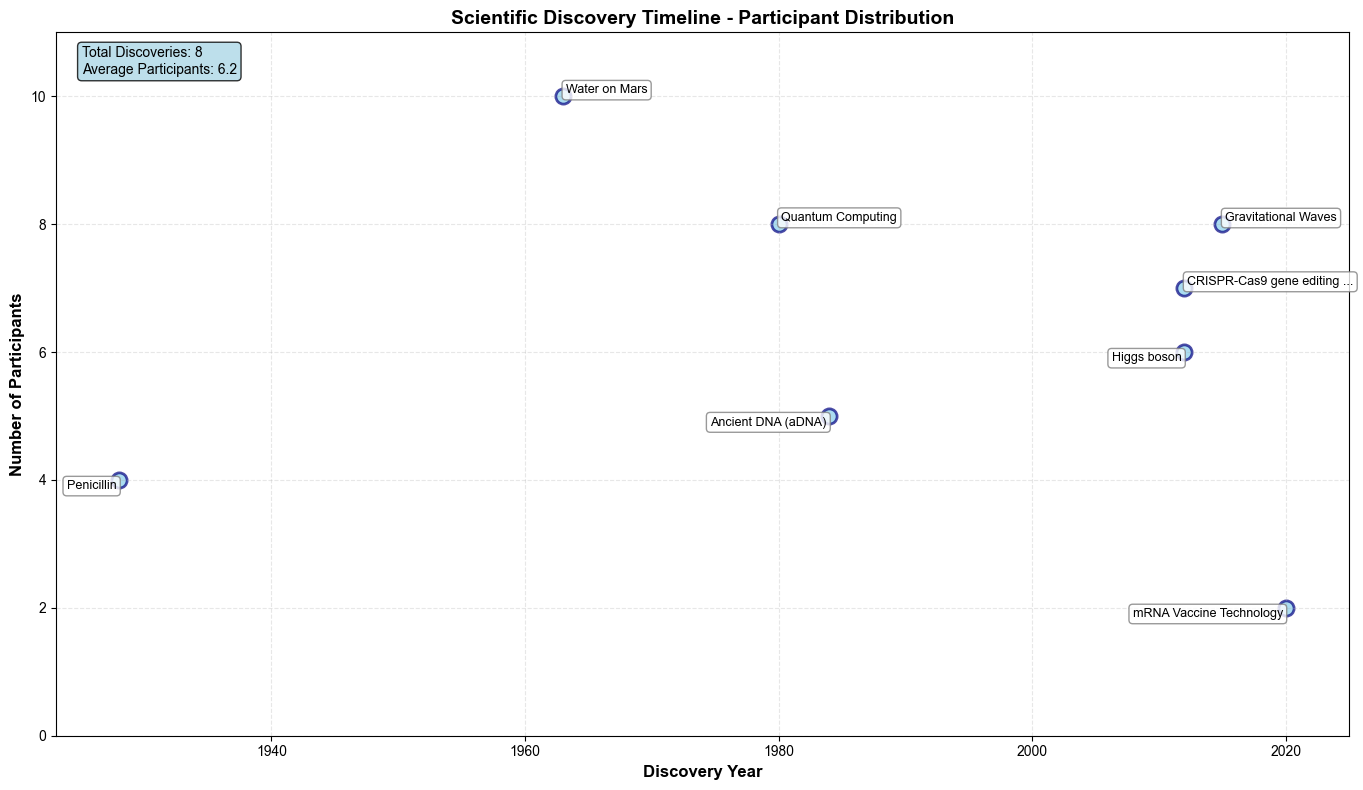

✅ Timeline chart created successfully
📊 Statistics: 8 discoveries, average 6.2 participants
👥 Creating discoverer network chart...


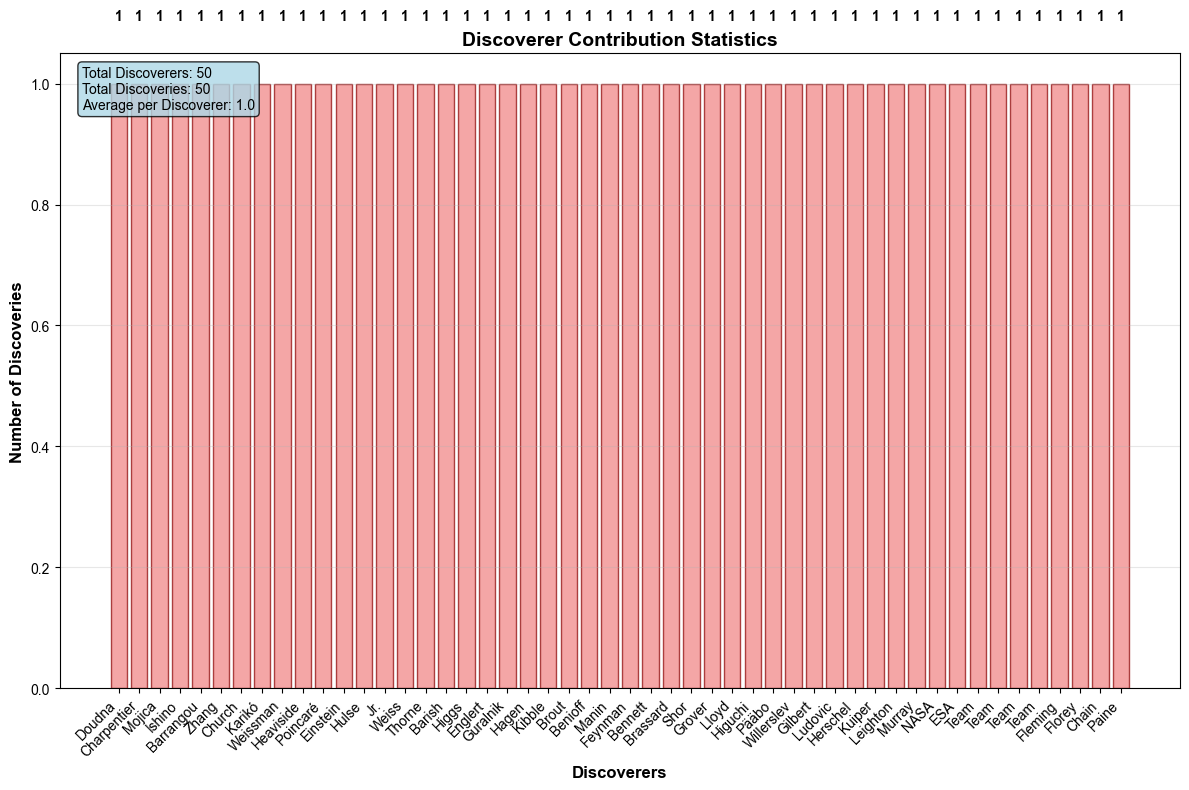

✅ Discoverer network chart created successfully
📊 Statistics: 50 discoverers, 50 total discoveries
📅 Creating discovery timeline chart...
📊 Plotting timelines for 8 discoveries


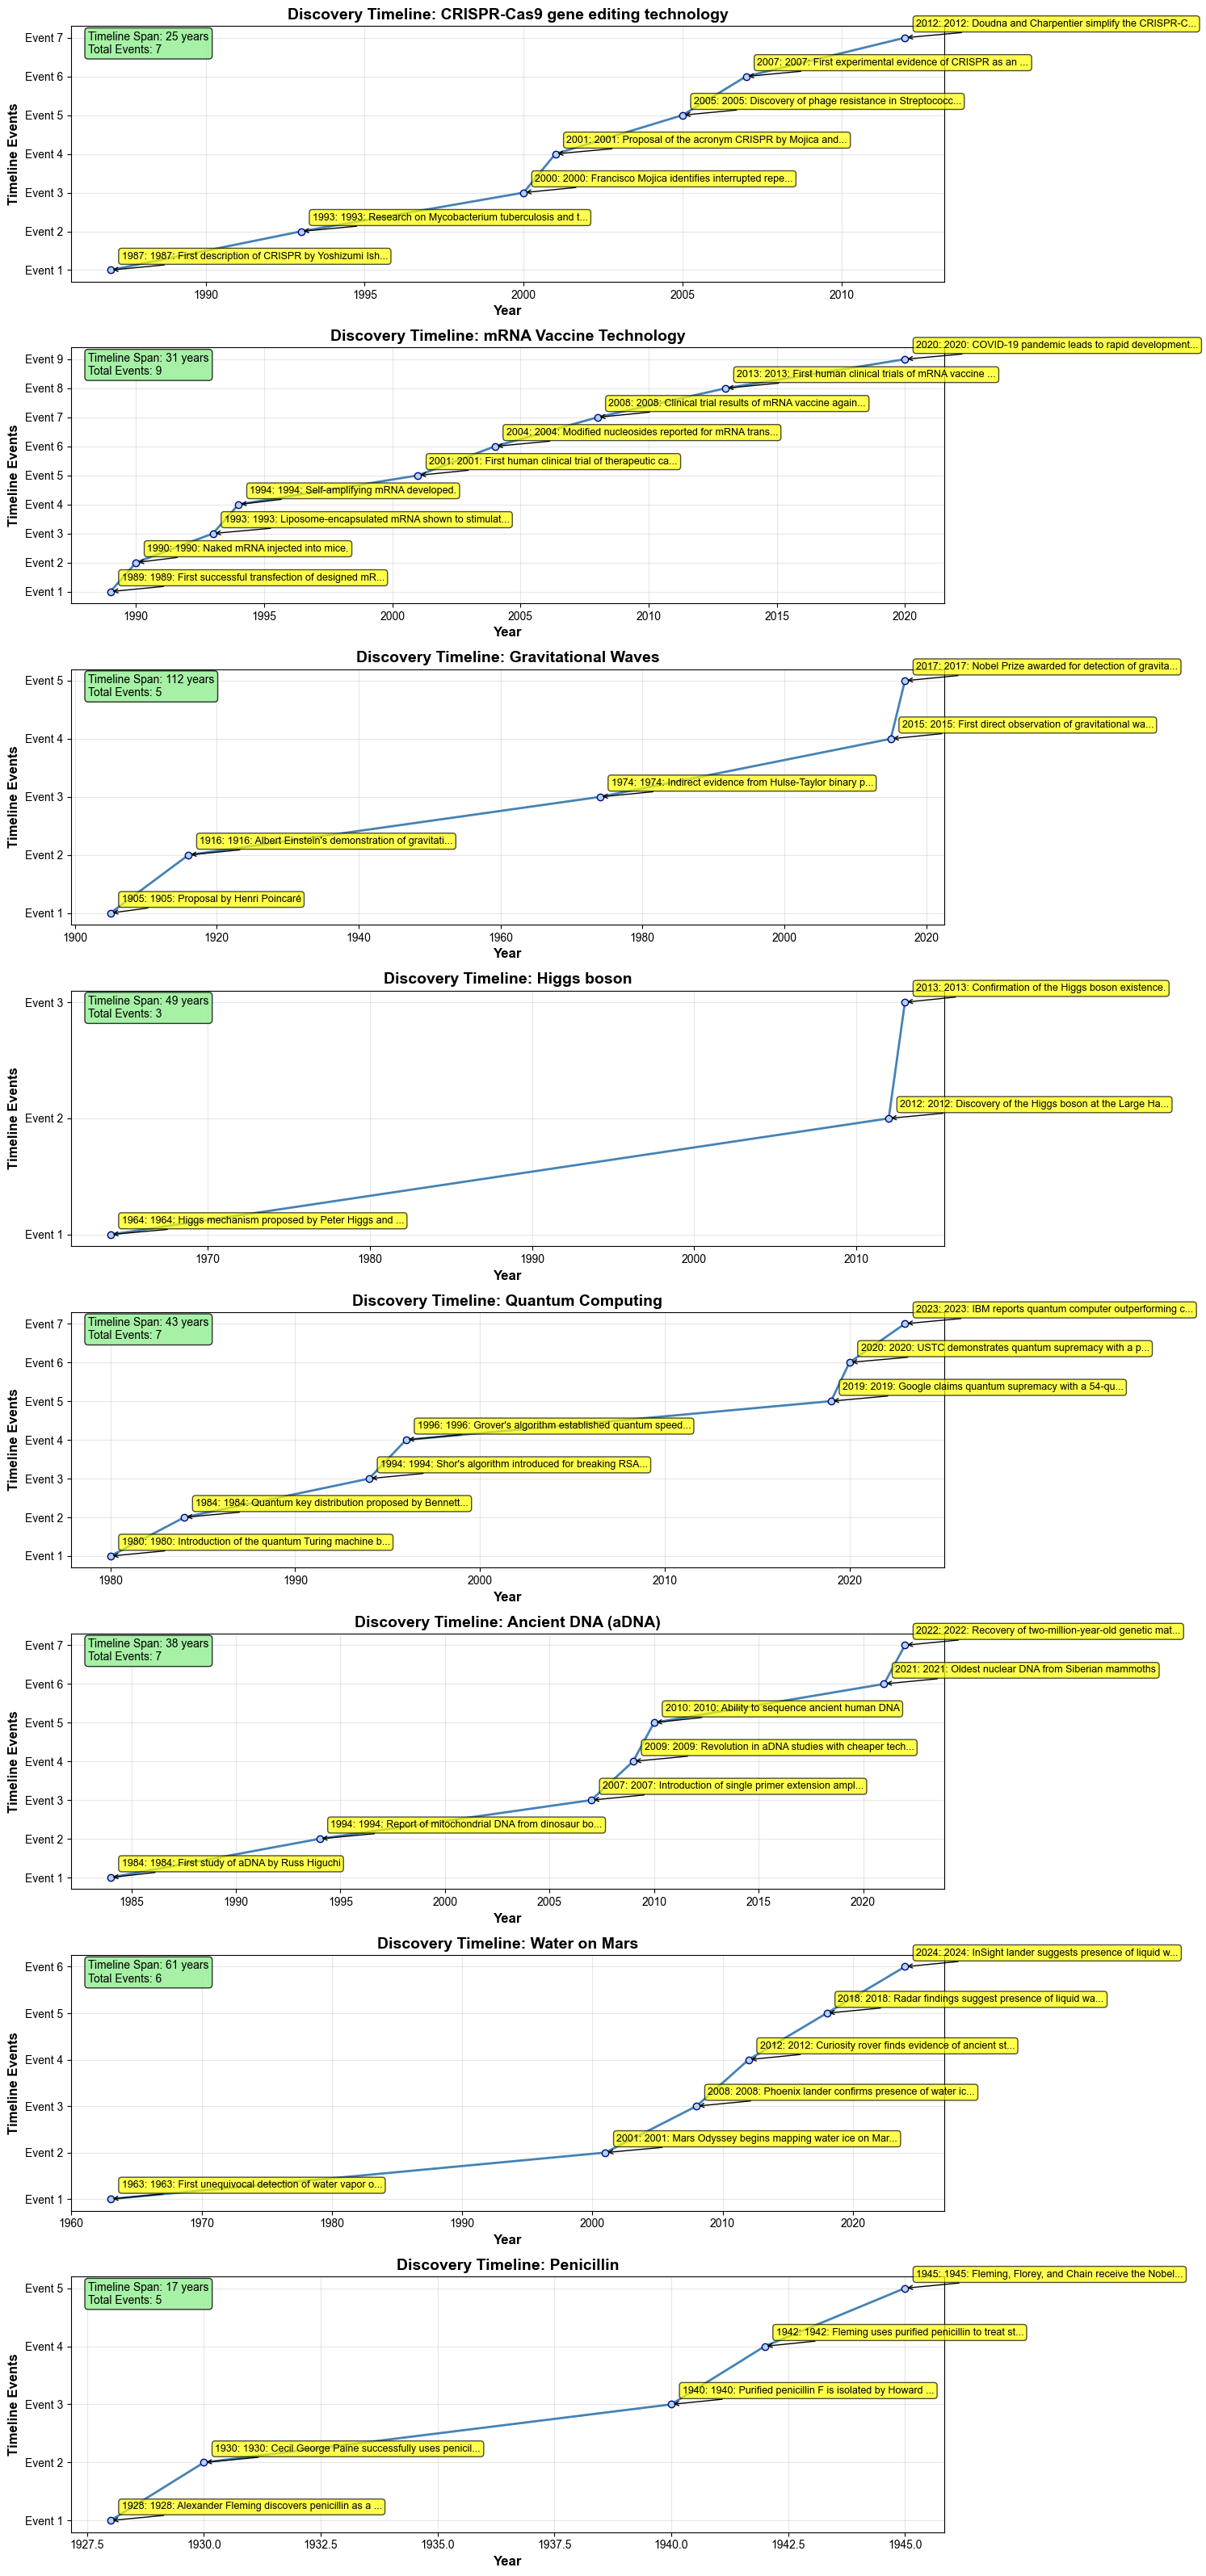

✅ Discovery timeline chart created successfully

✅ Full demo completed!

🎉 Part 4 demo completed!
📋 Demo Summary:
✅ 1. Full end-to-end workflow
✅ 2. Demonstration of all main features
✅ 3. Error handling example
✅ 4. Data visualization
✅ 5. Interactive assistant demo


In [ ]:
# Run the complete Part 4 demo
def run_part4_demo():
    """Run the complete Part 4 demo"""
    print("🎬 Starting Part 4: Integration and Demonstration")
    print("=" * 60)

    # Create demo instance
    demo = ComprehensiveDemo()

    # Run the complete pipeline (this function should be called with await in Jupyter)

    nest_asyncio.apply()
    asyncio.get_event_loop().run_until_complete(demo.run_complete_pipeline())

    print("\n🎉 Part 4 demo completed!")
    print("=" * 60)
    print("📋 Demo Summary:")
    print("✅ 1. Full end-to-end workflow")
    print("✅ 2. Demonstration of all main features")
    print("✅ 3. Error handling example")
    print("✅ 4. Data visualization")
    print("✅ 5. Interactive assistant demo")

# Execute the demo
run_part4_demo()
